In [315]:
#from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from sklearn.metrics.pairwise import cosine_similarity
from utils import *

#drive.mount('/content/drive')

In [280]:
INPUT_PATH = "./"
VECTORIZER = "vectorizer.pickle"
TWEETS = "df_tweets.csv"
W2V_MODEL = "word2vec.kvmodel"

In [243]:
#Download tweets datasset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16SdNcvSv5vMSVWhiMqTvPv4_fTUbRT0Y' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16SdNcvSv5vMSVWhiMqTvPv4_fTUbRT0Y" -O hydrated_tweets.json && rm -rf /tmp/cookies.txt

sed: illegal option -- r
usage: sed script [-Ealn] [-i extension] [file ...]
       sed [-Ealn] [-i extension] [-e script] ... [-f script_file] ... [file ...]
--2020-12-09 16:35:26--  https://docs.google.com/uc?export=download&confirm=&id=16SdNcvSv5vMSVWhiMqTvPv4_fTUbRT0Y
Resolving docs.google.com (docs.google.com)... 216.58.211.238
Connecting to docs.google.com (docs.google.com)|216.58.211.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘hydrated_tweets.json’

hydrated_tweets.jso     [ <=>                ]   3.18K  --.-KB/s    in 0s      

2020-12-09 16:35:26 (12.5 MB/s) - ‘hydrated_tweets.json’ saved [3260]



In [248]:
# Download vectorizer
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-14RBWKT1lR0QxFxFnkIbClgtJLpT5q9' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-14RBWKT1lR0QxFxFnkIbClgtJLpT5q9" -O vectorizer.pickle && rm -rf /tmp/cookies.txt

sed: illegal option -- r
usage: sed script [-Ealn] [-i extension] [file ...]
       sed [-Ealn] [-i extension] [-e script] ... [-f script_file] ... [file ...]
--2020-12-09 16:39:49--  https://docs.google.com/uc?export=download&confirm=&id=1-14RBWKT1lR0QxFxFnkIbClgtJLpT5q9
Resolving docs.google.com (docs.google.com)... 216.58.211.238
Connecting to docs.google.com (docs.google.com)|216.58.211.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://docs.google.com/uc?export%3Ddownload%26confirm%26id%3D1-14RBWKT1lR0QxFxFnkIbClgtJLpT5q9&followup=https://docs.google.com/uc?export%3Ddownload%26confirm%26id%3D1-14RBWKT1lR0QxFxFnkIbClgtJLpT5q9&ltmpl=homepage [following]
--2020-12-09 16:39:50--  https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://docs.google.com/uc?export%3Ddownload%26confirm%26id%3D1-14RBWKT1lR0QxFxFnkIbClgtJLpT5q9&foll

### Create the model class

In [305]:
class TfIdf_Word2Vec_Sim():
    def __init__(self, vector_size=100, model_path = INPUT_PATH + W2V_MODEL):
        self.df_tweets, self.tf_idf, self.vectorizer = self._load_tfidf_vectorizer(TWEETS)
        self.vector_size = 100
        self.corpus = process_docs(df_tweets['clean_text'].values)
        self.model = Word2Vec.load(model_path)
        
    def word_embedding(self):
        """
            Create word embedding matrix.
            Input: Model and vector size
            Output: (vocab_len x vector_size) matrix with word embeddings in each row
        """
        vocab = self.model.wv.vocab
        vocab_len = len(self.model.wv.vocab)

        embedding_matrix = np.zeros((vocab_len, self.vector_size))
        for i, word in enumerate(vocab):
            if word in self.model:
                embedding_matrix[i] = self.model[word]

        return embedding_matrix

    def _get_word_index_map(self):
        """
            Input: Model
            Output: wrod index mapping
        """
        vocab = self.model.wv.vocab
        word_map_index = {}

        for i in enumerate(vocab):
            word_map_index[i[1]] = i[0]

        return word_map_index
    
    def doc_embedding(self, embedding_matrix):
        """
            Generate document embedding
            Input: Model, vector size, corpus of docs, embedding_matrix
            Output: doc embeddings as matrix
        """
        word_map_index = _get_word_index_map()

        document_word_embeddings = np.zeros((len(self.corpus),self.vector_size))
        for i in range(len(self.corpus)):
            for j in range(len(self.corpus[i])):
                document_word_embeddings[i] += embedding_matrix[word_map_index[corpus[i][j]]]
            document_word_embeddings[i] = document_word_embeddings[i]/len(corpus[i])

        return document_word_embeddings
    
    def query_embedding(self, query, embedding_matrix):
        """
            Query embedding
            Input: query, model, vector size, word embeddings
            Output: query embedding as matrix
        """
        vocab = self.model.wv.vocab
        query_corpus = []
        for q in query:
            q_ = preprocess_string(q)
            query_corpus.append([i for i in q_ if i in vocab]) 
        word_map_index = _get_word_index_map()

        query_em = np.zeros((len(query),self.vector_size))
        for i in range(len(query)):
            for j in range(len(query_corpus)):
                query_em[i] += embedding_matrix[word_map_index[query_corpus[i][j]]]
            query_em[i] = query_em[i]/len(query_corpus[i])

        return query_em
    
    def return_top_n_doc_word2vec(self, query, n, vector_size=100, show=True):
        """
        query: Query that the user writes.
        tf_idf: dataframe containing tfidf weights for each word in each doc
        n: number of doc to return to the user
        show: if you want to visualize the results

        returns a list with the most top n relevant tweets
        """
        word_embeddings = word_embedding(self.model, self.vector_size)
        doc_embeddings = doc_embedding(self.model, self.vector_size, self.corpus, word_embeddings)
        query = query_embedding(query, self.model, self.vector_size, word_embeddings)

        results = cosine_similarity(doc_embeddings, query)
        results = results.flatten()

        documents_retrieved = []
        rank=0

        for i in results.argsort()[-n:][::-1]:
            user_name, text, url, hashtags, favorites, retweets = get_tweet_fields(self.df_tweets,i)
            if show == True:
                print("-->",rank + 1 )
                print(text," | ",user_name," | ",self.df_tweets.iloc[i]['created_at']," | ", hashtags[:] ," | ",favorites," | ", retweets," | ",url)
            documents_retrieved.append(i)
            rank +=1

        return documents_retrieved, results, doc_embeddings,word_embeddings
    
    def return_top_n_doc_tfidf(self, query, n, show = True, authority = None):
        """
        query: Query that the user writes.
        tf_idf: dataframe containing tfidf weights for each word in each doc
        n: number of doc to return to the user
        show: if you want to visualize the results

        returns a list with the most top n relevant tweets
        """
        query = clean_text(query) #noramalize the query
        query_vec = self.vectorizer.transform([query]) #calculate tdidf
        results = cosine_similarity(self.tf_idf, query_vec)
        results = results.flatten()

        documents_retrieved = []
        #######Return the results#########
        rank=0

        if authority is not None:
              results += 0.1*authority

        for i in results.argsort()[-n:][::-1]:
            user_name, text, url, hashtags, favorites, retweets = get_tweet_fields(self.df_tweets,i)
            if show == True:
                print("The query is:", query)
                print("-->",rank + 1 )
                print(text," | ",user_name," | ",self.df_tweets.iloc[i]['created_at']," | ", hashtags[:] ," | ",favorites," | ", retweets," | ",url)
            documents_retrieved.append(i)
            rank +=1
        if show == True:
            print("\n")

        return documents_retrieved, results
        
    def process_docs(self, docs):
        """
            Input: docs: Array of strings
            Output: Processed input, for word2vec
        """
        docs_ = []
        for doc in docs:
            docs_.append(preprocess_string(doc,filters=[])) # we have already performed some processing. We only want to split by white space.

        return docs_

    def _load_tfidf_vectorizer(self, dataset):
        # LOAD vectorizer
        vectorizer = pickle.load(open(INPUT_PATH + VECTORIZER, "rb"))

        # Load corpus
        df_tweets = pd.read_csv(INPUT_PATH + dataset)
        corpus = df_tweets['clean_text']
        corpus = corpus.fillna('')
        tf_idf = vectorizer.transform(corpus)

        return df_tweets,tf_idf, vectorizer

In [302]:
# Instantiate the model
model = TfIdf_Word2Vec_Sim()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 1st RQ - Output Analysis 

### a. Chosing 10 queries


Select terms based on the popularity. We will select terms depending on the average tf idfs they have.


In [291]:
# Load vectorizer and database
df_tweets = model.df_tweets
tf_idf = model.tf_idf
vectorizer = model.vectorizer

In [292]:
tf_idf_tokens = vectorizer.get_feature_names() # take the words
df_tfidf = pd.DataFrame.sparse.from_spmatrix(data=tf_idf, columns=tf_idf_tokens)#Dataframe each row is a doc and each col a word

In [293]:
mean_tfidfs = df_tfidf[df_tfidf.columns].mean()

The following are the main words in the dataset by tf-idf:

In [294]:
print(mean_tfidfs.sort_values(axis=0, ascending=False, inplace=False)[:20])

covid         0.041307
covid19       0.022242
peopl         0.015768
get           0.013358
test          0.012097
coronaviru    0.011866
death         0.011131
die           0.010195
go            0.009831
vaccin        0.009775
case          0.009720
like          0.009431
trump         0.009278
dont          0.009246
mask          0.009169
us            0.008908
one           0.008533
new           0.008238
amp           0.008171
say           0.007968
dtype: float64


In [295]:
query_list = ['Why does trump not wear a mask?',
              'News from covid',
              'When will the covid vaccine be available?',
              'How many people has died from covid?',
              'Covid deaths england November',
              'Covid total number of tests',
              'What does trump say about covid?',
              'Covid impact Amazon company',
              'Covid vaccine trials',
              'Covid death rate'
              ]

### b. Return a top-20 list of documents for each of the 10 queries, using tf-idf + cosine similarity methods 

In [304]:
queries_results = {}
index = 0
for query in query_list:
    doc_retrieved = model.return_top_n_doc_tfidf(query,20,show=True)
    queries_results[index] = doc_retrieved  
    index += 1

trump wear mask
--> 1
Wear a mask   |  Lorraine S. Haake  |  2020-11-19 16:54:53+00:00  |  ['No hashtags']  |  1  |  0  |  https://t.co/Gl02vE284h
trump wear mask
--> 2
"Wear a Mask" 😷   |  Putnam Progressives  |  2020-11-19 16:31:04+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/OsIEJLfMS1
trump wear mask
--> 3
Wear a mask!   |  🌴☀️ SwaltyComputerChick.com  |  2020-11-19 15:56:24+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/yvvMxaXzFj
trump wear mask
--> 4
Wear a mask!   |  CFO Enterprise, LLC  |  2020-11-19 16:29:11+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/IBDGV58zZS
trump wear mask
--> 5
WEAR A MASK   |  Blitz Gamer (Black Lives Matter, Trump is gone!)  |  2020-11-19 17:36:15+00:00  |  ['No hashtags']  |  1  |  0  |  https://t.co/2JditgVNRE
trump wear mask
--> 6
Wear a mask!   |  Carrie  |  2020-11-19 15:51:24+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/J70qIBFBrs
trump wear mask
--> 7
WEAR. A. MASK!!!   |  Sue Cottingham  |  2020-11-19 17:

mani peopl die covid
--> 1
How many died from ONLY covid?   |  President Elect Cyncha  |  2020-11-19 16:20:50+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/GKH8h1aDhs
mani peopl die covid
--> 2
@realDonaldTrump @OANN How many have died from COVID?  |  linda  |  2020-11-19 16:45:16+00:00  |  ['No hashtags']  |  0  |  0  |  None
mani peopl die covid
--> 3
@govkristinoem Did that many die from Covid?  |  🐘 One Term Don the Impeached Clown 🐘  |  2020-11-19 17:03:52+00:00  |  ['No hashtags']  |  2  |  0  |  None
mani peopl die covid
--> 4
But how many people are still dying?   |  Brad Thompson  |  2020-11-19 17:08:03+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/NQAyyEn5It
mani peopl die covid
--> 5
@realDonaldTrump If it's so available for so many people and doing great, then why are so many people still dying from Covid?  |  SHOE-SO-CRAZY!  |  2020-11-19 15:47:43+00:00  |  ['No hashtags']  |  0  |  0  |  None
mani peopl die covid
--> 6
@LifeNewsHQ @DrShayPhD How many peo

--> 12
Our total number of cases is now 203   |  Nelcia Charlemagne  |  2020-11-19 17:47:23+00:00  |  ['No hashtags']  |  3  |  4  |  https://t.co/8sarTnJOiJ
covid total number test
--> 13
This is totally next...   |  Laura P Bradley  |  2020-11-19 17:46:19+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/unN1403NU3
covid total number test
--> 14
It totally IS about control.   |  Helen Fox  |  2020-11-19 15:53:43+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/CZ0oStrnhG
covid total number test
--> 15
“The @WHO recommended in May that a percent positive rate (total positives divided by total completed tests) of below 5% for at least two weeks is necessary to safely reopen the economy. That 5% threshold is based on total positives divided by total tests.”   |  Jackie Craig (she, her)  |  2020-11-19 17:14:21+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/jRrZ0qHR7u
covid total number test
--> 16
@SmithTootie Totally agree!
  |  A Radical Moderate  |  2020-11-19 17:19

covid vaccin trial
--> 14
Want to participate in a covid vaccine trial? Here is the link for Canadians:   |  Sheri Frantz  |  2020-11-19 15:55:17+00:00  |  ['No hashtags']  |  1  |  0  |  https://t.co/K1MyzhR1bH
covid vaccin trial
--> 15
After News of Promising Vaccine Trials, Coronavirus Vaccine Comfort Starts to Tick Up  https://t.co/LdNE7lgtkn  |  Dr. Simon A. Rego  |  2020-11-19 17:04:01+00:00  |  ['No hashtags']  |  4  |  0  |  https://t.co/XKGFqPNOzC
covid vaccin trial
--> 16
@WenkhosiD @JanThaboj @OksalayoMxm @UmalambaneKZN Number 4, you dreaming or not scientific. CoVid vaccine trials are ongoing or happening, Botswana not in any vaccine trial or preparation. Read my friend. In Africa, check Wits University.  |  @NapoleonII_SA  |  2020-11-19 17:35:32+00:00  |  ['No hashtags']  |  0  |  0  |  None
covid vaccin trial
--> 17
Watch what happens inside a Chinese Covid-19 vaccine trial  |  Mazi Urch_mann  |  2020-11-19 15:57:00+00:00  |  ['No hashtags']  |  0  |  0  |  None
covid vac

### c. Return a top-20 list of documents for each of the 10 queries, using word2vec + cosine similarity. 

In [306]:
queries_results_w2v = {}
index = 0
for query in query_list:
    rel_tweets_word2vec, res_word2vec,doc_emb,word_emb = model.return_top_n_doc_word2vec([query], 
                                                                                         20, 
                                                                                         show=True)
    queries_results_w2v[index] = (rel_tweets_word2vec, res_word2vec)
    index += 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


--> 1
Trump🇺🇸🇺🇸🇺🇸   |  Vivian h  |  2020-11-19 16:47:49+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/3VyToQVVGn
--> 2
Trump   |  mai  |  2020-11-19 16:39:16+00:00  |  ['No hashtags']  |  1  |  0  |  https://t.co/0gEnwPUfgU
--> 3
Trump won again, again   |  Gypsy  |  2020-11-19 16:52:36+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/ftchu41gDd
--> 4
TRUMP!   |  OldManBeaston  |  2020-11-19 16:54:24+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/fqaNocjvKx
--> 5
Trump doing !   |  shipboss  |  2020-11-19 15:51:29+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/132mcUaNCw
--> 6
Trump is #KidVicious   |  Anne Aldrich  |  2020-11-19 16:42:41+00:00  |  [{'text': 'KidVicious', 'indices': [9, 20]}]  |  0  |  0  |  https://t.co/whPjhthYQQ
--> 7
Trump filth.👎👎   |  Mister_Bill Resists🌊🌊  |  2020-11-19 16:37:55+00:00  |  ['No hashtags']  |  0  |  1  |  https://t.co/uR4FIba9Ny
--> 8
this insufferable prick is why trump won   |  joe biden’s mouth crust  |  2020-11-1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


--> 1
New on  | Behavioural Science and a Post-COVID World | https://t.co/SVie2jtpqj  |  Gary Holden  |  2020-11-19 17:38:06+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/8pxKdRDxAR
--> 2
NEW (): After discussing Cast Member layoffs, the hosts think about the future of entertainment in Disney Parks and what they think will and won't return once the COVID pandemic subsides. https://t.co/xelJO5SeQW  |  Station 71: A Walt Disney World Podcast  |  2020-11-19 16:00:58+00:00  |  ['No hashtags']  |  1  |  0  |  https://t.co/lx3X9Vi7mW
--> 3
1210 new
1376 resolved   |  Patrik Darabont  |  2020-11-19 16:45:22+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/NuZFp6C4xm
--> 4
queen of new zealand   |  julia  |  2020-11-19 16:54:57+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/MDUC1BUWu8
--> 5
Our new, gawdawfull reality.   |  Billy Waldo  |  2020-11-19 17:14:37+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/js9joJ52sI
--> 6
New eco friendly Bleach   |  imalicious❄️

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


--> 1
@MarkHoliday17 @notaproviderMD @RepDanCrenshaw Covid  |  Sailor Deadpool  |  2020-11-19 17:01:01+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 2
@JonErlichman S/O covid  |  Salamanda  |  2020-11-19 15:46:34+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 3
@Prifiscifilafa Covid...  |  💀 𝕷𝖔𝖈𝖔𝕯𝖊𝕷𝖔𝖟𝖆𝖓𝖓𝖊 💀  |  2020-11-19 15:33:14+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 4
@ARYNEWSOFFICIAL Covid?  |  Ali  |  2020-11-19 17:31:55+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 5
@Mikey___Smith Covid!  |  Crazy Del 🎮🏆👑  |  2020-11-19 15:36:05+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 6
@DeTrop_ Covid  |  Sanjay Raja  |  2020-11-19 17:06:27+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 7
@kylenabecker @realDonaldTrump COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, 
COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID  |  Maria Tibbles  |  2020-11-19 16:09:37+00:00  |  ['No hashtags']  |  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


--> 1
These people....   |  adam  |  2020-11-19 17:28:42+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/7EKq5lxsew
--> 2
What can we do as the people do about this?   |  Gmac62  |  2020-11-19 16:09:07+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/1IP3wfUnsR
--> 3
it was just to dominate the people   |  Jose Manuel  |  2020-11-19 17:48:14+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/4EaEJb8HaW
--> 4
People + props   |  wow a red ghost-elect 🥞  |  2020-11-19 16:11:15+00:00  |  ['No hashtags']  |  1  |  0  |  https://t.co/dF4drq4yvw
--> 5
These people are such hypocrites.   |  Anthony Starke 🇺🇲  |  2020-11-19 17:49:10+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/RRvbYnKCLS
--> 6
People are awful.   |  tttam.  |  2020-11-19 16:35:50+00:00  |  ['No hashtags']  |  1  |  0  |  https://t.co/Y7M1I8TrZS
--> 7
🤣🤣🤣 These people are all dumber than a bag of hammers .. 🤡🤡   |  UPennProf  |  2020-11-19 17:15:29+00:00  |  ['No hashtags']  |  1  |  0  |  https://t.c

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


--> 1
@MarkHoliday17 @notaproviderMD @RepDanCrenshaw Covid  |  Sailor Deadpool  |  2020-11-19 17:01:01+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 2
@JonErlichman S/O covid  |  Salamanda  |  2020-11-19 15:46:34+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 3
@Prifiscifilafa Covid...  |  💀 𝕷𝖔𝖈𝖔𝕯𝖊𝕷𝖔𝖟𝖆𝖓𝖓𝖊 💀  |  2020-11-19 15:33:14+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 4
@ARYNEWSOFFICIAL Covid?  |  Ali  |  2020-11-19 17:31:55+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 5
@Mikey___Smith Covid!  |  Crazy Del 🎮🏆👑  |  2020-11-19 15:36:05+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 6
@DeTrop_ Covid  |  Sanjay Raja  |  2020-11-19 17:06:27+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 7
@kylenabecker @realDonaldTrump COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, 
COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID  |  Maria Tibbles  |  2020-11-19 16:09:37+00:00  |  ['No hashtags']  |  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


--> 1
@MarkHoliday17 @notaproviderMD @RepDanCrenshaw Covid  |  Sailor Deadpool  |  2020-11-19 17:01:01+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 2
@JonErlichman S/O covid  |  Salamanda  |  2020-11-19 15:46:34+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 3
@Prifiscifilafa Covid...  |  💀 𝕷𝖔𝖈𝖔𝕯𝖊𝕷𝖔𝖟𝖆𝖓𝖓𝖊 💀  |  2020-11-19 15:33:14+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 4
@ARYNEWSOFFICIAL Covid?  |  Ali  |  2020-11-19 17:31:55+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 5
@Mikey___Smith Covid!  |  Crazy Del 🎮🏆👑  |  2020-11-19 15:36:05+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 6
@DeTrop_ Covid  |  Sanjay Raja  |  2020-11-19 17:06:27+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 7
@kylenabecker @realDonaldTrump COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, 
COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID  |  Maria Tibbles  |  2020-11-19 16:09:37+00:00  |  ['No hashtags']  |  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


--> 1
Trump🇺🇸🇺🇸🇺🇸   |  Vivian h  |  2020-11-19 16:47:49+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/3VyToQVVGn
--> 2
Trump   |  mai  |  2020-11-19 16:39:16+00:00  |  ['No hashtags']  |  1  |  0  |  https://t.co/0gEnwPUfgU
--> 3
Trump won again, again   |  Gypsy  |  2020-11-19 16:52:36+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/ftchu41gDd
--> 4
TRUMP!   |  OldManBeaston  |  2020-11-19 16:54:24+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/fqaNocjvKx
--> 5
Trump doing !   |  shipboss  |  2020-11-19 15:51:29+00:00  |  ['No hashtags']  |  0  |  0  |  https://t.co/132mcUaNCw
--> 6
Trump is #KidVicious   |  Anne Aldrich  |  2020-11-19 16:42:41+00:00  |  [{'text': 'KidVicious', 'indices': [9, 20]}]  |  0  |  0  |  https://t.co/whPjhthYQQ
--> 7
Trump filth.👎👎   |  Mister_Bill Resists🌊🌊  |  2020-11-19 16:37:55+00:00  |  ['No hashtags']  |  0  |  1  |  https://t.co/uR4FIba9Ny
--> 8
this insufferable prick is why trump won   |  joe biden’s mouth crust  |  2020-11-1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


--> 1
@MarkHoliday17 @notaproviderMD @RepDanCrenshaw Covid  |  Sailor Deadpool  |  2020-11-19 17:01:01+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 2
@JonErlichman S/O covid  |  Salamanda  |  2020-11-19 15:46:34+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 3
@Prifiscifilafa Covid...  |  💀 𝕷𝖔𝖈𝖔𝕯𝖊𝕷𝖔𝖟𝖆𝖓𝖓𝖊 💀  |  2020-11-19 15:33:14+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 4
@ARYNEWSOFFICIAL Covid?  |  Ali  |  2020-11-19 17:31:55+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 5
@Mikey___Smith Covid!  |  Crazy Del 🎮🏆👑  |  2020-11-19 15:36:05+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 6
@DeTrop_ Covid  |  Sanjay Raja  |  2020-11-19 17:06:27+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 7
@kylenabecker @realDonaldTrump COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, 
COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID  |  Maria Tibbles  |  2020-11-19 16:09:37+00:00  |  ['No hashtags']  |  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


--> 1
@MarkHoliday17 @notaproviderMD @RepDanCrenshaw Covid  |  Sailor Deadpool  |  2020-11-19 17:01:01+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 2
@JonErlichman S/O covid  |  Salamanda  |  2020-11-19 15:46:34+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 3
@Prifiscifilafa Covid...  |  💀 𝕷𝖔𝖈𝖔𝕯𝖊𝕷𝖔𝖟𝖆𝖓𝖓𝖊 💀  |  2020-11-19 15:33:14+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 4
@ARYNEWSOFFICIAL Covid?  |  Ali  |  2020-11-19 17:31:55+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 5
@Mikey___Smith Covid!  |  Crazy Del 🎮🏆👑  |  2020-11-19 15:36:05+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 6
@DeTrop_ Covid  |  Sanjay Raja  |  2020-11-19 17:06:27+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 7
@kylenabecker @realDonaldTrump COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, 
COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID  |  Maria Tibbles  |  2020-11-19 16:09:37+00:00  |  ['No hashtags']  |  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


--> 1
@MarkHoliday17 @notaproviderMD @RepDanCrenshaw Covid  |  Sailor Deadpool  |  2020-11-19 17:01:01+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 2
@JonErlichman S/O covid  |  Salamanda  |  2020-11-19 15:46:34+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 3
@Prifiscifilafa Covid...  |  💀 𝕷𝖔𝖈𝖔𝕯𝖊𝕷𝖔𝖟𝖆𝖓𝖓𝖊 💀  |  2020-11-19 15:33:14+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 4
@ARYNEWSOFFICIAL Covid?  |  Ali  |  2020-11-19 17:31:55+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 5
@Mikey___Smith Covid!  |  Crazy Del 🎮🏆👑  |  2020-11-19 15:36:05+00:00  |  ['No hashtags']  |  0  |  0  |  None
--> 6
@DeTrop_ Covid  |  Sanjay Raja  |  2020-11-19 17:06:27+00:00  |  ['No hashtags']  |  1  |  0  |  None
--> 7
@kylenabecker @realDonaldTrump COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID, 
COVID, COVID, COVID, COVID, COVID, COVID, COVID, COVID  |  Maria Tibbles  |  2020-11-19 16:09:37+00:00  |  ['No hashtags']  |  

### d. Scatterplot TSNE algorithm



#### Scatter Plot DOCUMENTS (Word2Vec)

In [308]:
def run_TSNE(X,df_tweets = None,labels = None, doc = False,name = 'default.png'):
    """
    X: matrix containing the embeddings
    model: word2vec trained model (Gensim library)
    df_tweets: Only needed if we are printing doc. Database with tweets information 
    labels: text we want that the scatters have
    doc: If true we will be printing doc embeddings. If False, printing word embeddings


    Return: X_tsne matrix containing 2D representation of the embeddings.
    """
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)

    x  = X_tsne[:, 0]
    y = X_tsne[:, 1]

    if doc:
        labels = [df_tweets.iloc[n]['id_str'] for n in range(0,len(x))]
    if labels:
        fig, ax = plt.subplots(figsize=(15,15))
        plt.scatter(x, y)
        #for i, txt in enumerate(labels):
            #ax.annotate(txt, (x[i], y[i]))
        plt.savefig(results_path + name)
        plt.show()
    return X_tsne

In [13]:
labels = []
N=5000
for i in model.wv.vocab.keys():
    labels.append(i)

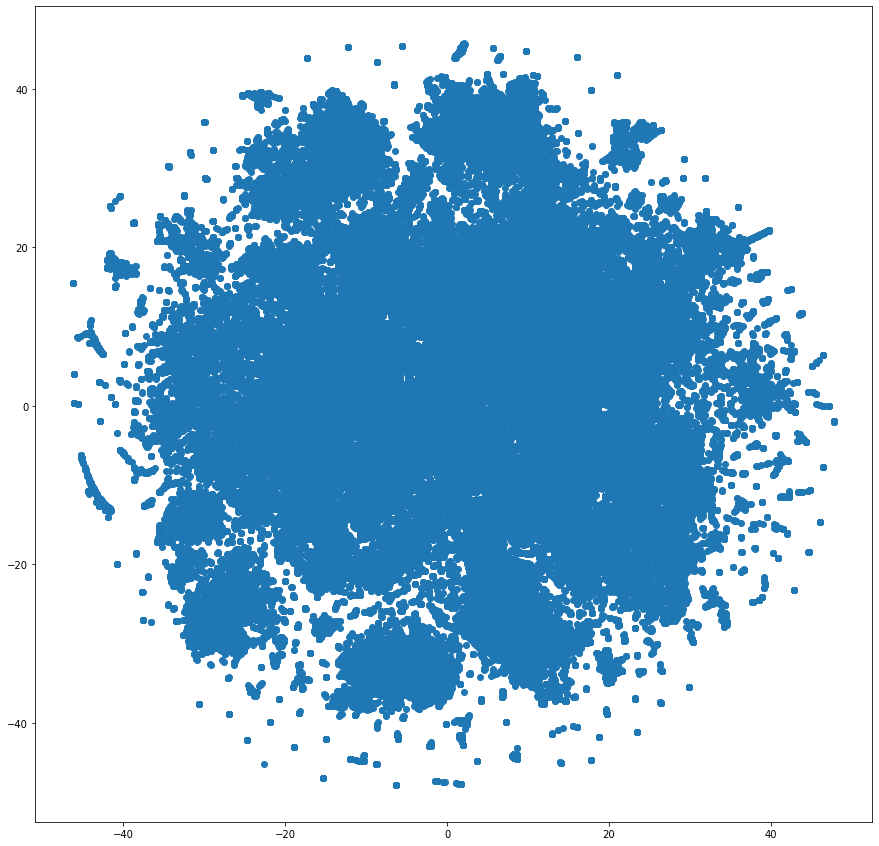

In [ ]:
doc_tsne_rep = run_TSNE(doc_embeddings,df_tweets=df_tweets,doc=True)

In [ ]:
#np.save(results_path + 'doc_rep_TSNE',doc_tsne_matrix)

#### Deciding the number of clusters with a dendogram

In [45]:
# Load doc tsne representation
doc_tsne_rep = np.load('doc_rep_TSNE.npy')

# Sampling document embeddings to avoid kernel crashes
N = 55000
doc_tsne_rep_downsample = doc_tsne_rep[:N]

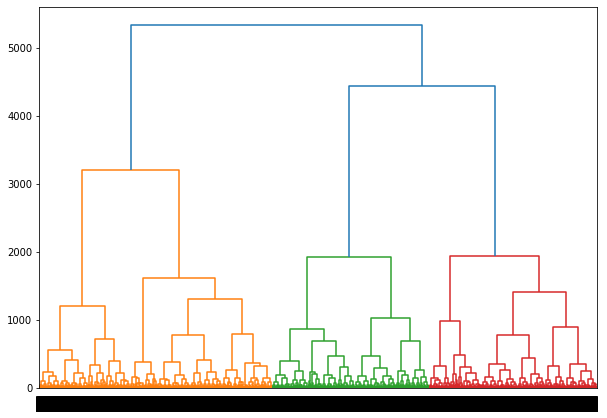

In [30]:
linked = sch.linkage(doc_tsne_rep_downsample, 'ward')

plt.figure(figsize=(10, 7))
sch.dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

#### Perform Agglomerative Clustering

In [36]:
clustering_docs = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward').fit(doc_tsne_rep_downsample)
cluster_labels_docs  = clustering_docs.labels_

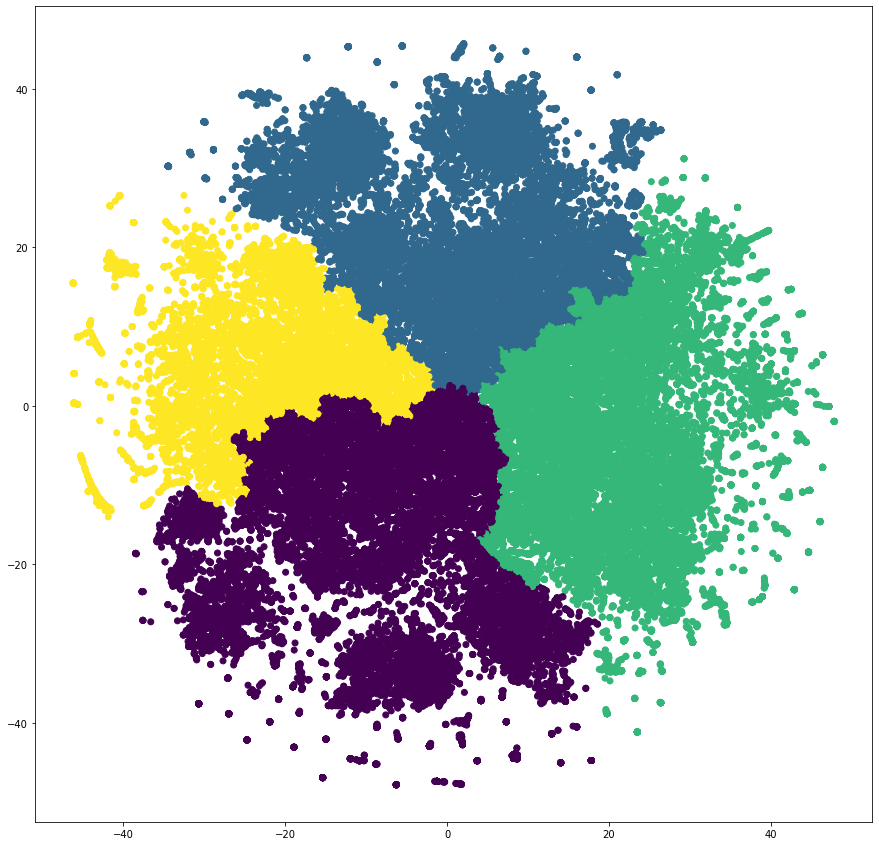

In [314]:
print_cluster(doc_tsne_rep_downsample,[i for i in range(len(doc_tsne_rep_downsample))],cluster_labels_docs)

In [38]:
#np.save('cluster_labels_docs_4_clusters.npy', arr=cluster_labels_docs)

In [191]:
cluster_labels_docs = np.load("cluster_labels_docs_4_clusters.npy")
df_tweets_downsampled = df_tweets.iloc[:N]

#### RQ 1A - Are you able to detect some subgroups within your tweets representation? Are you able to perform some clustering over the tweets and detect some topics within the conversation? How do you choose the best possible number of clusters?

In [192]:
df_tweets_downsampled["Cluster_Label"] = cluster_labels_docs

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [316]:
cluster_0 = df_tweets_downsampled[df_tweets_downsampled["Cluster_Label"]==0].reset_index()['clean_text']
print(1, cluster_0[0], '\n')
print(2, cluster_0[1], '\n')
print(3, cluster_0[2], '\n')
print(4, cluster_0[3], '\n')
print(5, cluster_0[4], '\n')

1 wow us alreadi hit 250k death covid 84 911 attack 4311 la vega shoot 2017 9260 sandi hook shoot 2012 11364 el paso shoot 2019 2 ww1 death 233032 sad heart lost love one 

2 meanwhil air canada book flight #rdu januari #travel #coronavirus #covid19 

3 sick hear covid19 #poll #coronavirus 

4 announc vaccinespecif #cpt code coronaviru immun #covid19 

5 coronaviru evolv whether get deadlier may depend us 



In [317]:
cluster_1 = df_tweets_downsampled[df_tweets_downsampled["Cluster_Label"]==1].reset_index()['clean_text']
print(1, cluster_1[0], '\n')
print(2, cluster_1[1], '\n')
print(3, cluster_1[2], '\n')
print(4, cluster_1[3], '\n')
print(5, cluster_1[4], '\n')

1 end day healthi work eat good realli way prevent lessen covid 19 symptom 

2 excit final join chapter cant wait start go event covid 

3 hate sick hope dont got covid famili thanksgiv 

4 black veil bride guitarist jinxx test posit coronaviru 

5 doubl covid risk 



In [318]:
cluster_2 = df_tweets_downsampled[df_tweets_downsampled["Cluster_Label"]==2].reset_index()['clean_text']
print(1, cluster_2[0], '\n')
print(2, cluster_2[1], '\n')
print(3, cluster_2[2], '\n')
print(4, cluster_2[3], '\n')
print(5, cluster_2[4], '\n')

1 women go food bank bc covid lockdown democrat offici get take retreat hawaii make sens 

2 peopl deserv get covid19 mcconnel top list 

3 asymptomat peopl fine mix symptom anyth flu pneumonia covid etc alway done gener see person dont need state fearmong everyon didnt worri 2016 flue epidem kill 65k 

4 guy want anoth covid thread work updat symptom recommend thing seeinghear first hand im definit tri lectur ppl sorri seem way im tri help 

5 omg know know plan world tour covid hit 



In [319]:
cluster_3 = df_tweets_downsampled[df_tweets_downsampled["Cluster_Label"]==3].reset_index()['clean_text']
print(1, cluster_3[0], '\n')
print(2, cluster_3[1], '\n')
print(3, cluster_3[2], '\n')
print(4, cluster_3[3], '\n')
print(5, cluster_3[4], '\n')

1 amazon covid19 influenc 2020 season hire trend 

2 believ outlier medic field suggest covid youd believ 98 medic commun grift 

3 india worsthit among major economi long covid report hsbc hold plc said india potenti growth could drop 5 postpandem world 6 eve outbreak 7 global financi crisi 

4 check 5 #retailmarketing tip 2020 #holidayseason #covid19 busi 2 commun 

5 noth wrong covid student wish attend exam believ that hisher right institut came offlin exam utter chao institut thought remedi conduct exam student #icaideniessafety 



#### RQ 1B - What are the 5 most relevant keywords in the tweets that are part of each cluster? To what extent these keywords characterize/separate well the clusters?

In [320]:
cluster_0_join = ' '.join(cluster_0.values)
cluster_1_join = ' '.join(cluster_1.values)
cluster_2_join = ' '.join(cluster_2.values)
cluster_3_join = ' '.join(cluster_3.values)

# Get top 20 most common words
clust_0_freq = nltk.FreqDist(standardize_text(cluster_0_join, 'english').split(' ')).most_common(20)
clust_1_freq = nltk.FreqDist(standardize_text(cluster_1_join, 'english').split(' ')).most_common(20)
clust_2_freq = nltk.FreqDist(standardize_text(cluster_2_join, 'english').split(' ')).most_common(20)
clust_3_freq = nltk.FreqDist(standardize_text(cluster_3_join, 'english').split(' ')).most_common(20)

# Remove intersection between most common words in clusters
common_words = set([i[0] for i in clust_0_freq]).intersection([i[0] for i in clust_1_freq]).intersection([i[0] for i in clust_2_freq]).intersection([i[0] for i in clust_3_freq])

In [321]:
# Print clusters main words
clust_0_freq = [(i[0],i[1]) for i in clust_0_freq if i[0] not in common_words][:5]
clust_0_freq

[('death', 3080),
 ('vaccin', 2471),
 ('case', 1879),
 ('coronaviru', 1441),
 ('new', 1295)]

In [322]:
clust_1_freq = [(i[0],i[1]) for i in clust_1_freq if i[0] not in common_words][:5]
clust_1_freq

[('test', 3258), ('mask', 2328), ('get', 2206), ('go', 1560), ('im', 1397)]

In [323]:
clust_2_freq = [(i[0],i[1]) for i in clust_2_freq if i[0] not in common_words][:5]
clust_2_freq

[('trump', 2450), ('die', 2099), ('get', 1603), ('dont', 1561), ('like', 1552)]

In [324]:
clust_3_freq = [(i[0],i[1]) for i in clust_3_freq if i[0] not in common_words][:5]
clust_3_freq

[('coronaviru', 1043),
 ('health', 972),
 ('new', 828),
 ('pandem', 787),
 ('hospit', 723)]

In [327]:
# Count the percentage of tweets where the mainwords appear in each cluster 
clust_0_pct = []
for word, c in clust_0_freq:
    count_tweets = 0
    for i in range(len(cluster_0)):
        if word in cluster_0.values[i]:
            count_tweets += 1
    clust_0_pct.append((word, count_tweets, count_tweets/len(cluster_0)*100))
    
clust_0_pct

[('death', 2347, 14.188984946496586),
 ('vaccin', 2189, 13.233782721721782),
 ('case', 1560, 9.431110573725892),
 ('coronaviru', 2098, 12.683634604921105),
 ('new', 1970, 11.909799891179492)]

In [328]:
clust_1_pct = []
for word, c in clust_1_freq:
    count_tweets = 0
    for i in range(len(cluster_1)):
        if word in cluster_1.values[i]:
            count_tweets += 1
    clust_1_pct.append((word, count_tweets, count_tweets/len(cluster_1)*100))
    
clust_1_pct

[('test', 2862, 20.336815178000425),
 ('mask', 2007, 14.261351524195268),
 ('get', 2174, 15.448021033184112),
 ('go', 3386, 24.06025723015704),
 ('im', 3110, 22.099054927876075)]

In [329]:
clust_2_pct = []
for word, c in clust_2_freq:
    count_tweets = 0
    for i in range(len(cluster_2)):
        if word in cluster_2.values[i]:
            count_tweets += 1
    clust_2_pct.append((word, count_tweets, count_tweets/len(cluster_2)*100))
    
clust_2_pct

[('trump', 2329, 15.082243232741874),
 ('die', 1887, 12.219919699520787),
 ('get', 1674, 10.840564693692526),
 ('dont', 1420, 9.19570003885507),
 ('like', 1453, 9.409402927081985)]

In [330]:
clust_3_pct = []
for word, c in clust_3_freq:
    count_tweets = 0
    for i in range(len(cluster_3)):
        if word in cluster_3.values[i]:
            count_tweets += 1
    clust_3_pct.append((word, count_tweets, count_tweets/len(cluster_3)*100))
    
clust_3_pct

[('coronaviru', 1201, 13.42799642218247),
 ('health', 1070, 11.963327370304116),
 ('new', 1107, 12.37701252236136),
 ('pandem', 811, 9.0675313059034),
 ('hospit', 638, 7.133273703041144)]